# Anomaly Detection for POS System

The business needs to know if there is a way to anticipate a failure in the POS system.

The data are the logs of POS system, in the **EzSystem.dbo.t_ezsystem_translog** table.

The data to be created from this table is the percentage of transactions for each transaction type by:
 - Year
 - Month
 - Day
 - Weekday (Mon - Sun)
 - Hour
 - Minute

**In other words: A percentage transaction time series at hour level for each transaction type since 2019.**

The data also includes in which minutes a system error ocurred.

## Data Layout

The data created in SQL have these columns:

|  Column  |  Description  |
|:--------:|:-------------:|
|   Year   | Transaction date Year |
|  Month   | Transaction date Month |
|   Day    | Transaction date Day |
|   Hour   | Transaction date Hour |
| Minute   | Transaction date Minute |
|  Weekday | Transaction date Weekday (Monday - Sunday) |
|  transType | Transaction Type. Example: 301001-LN-Loan |
|  num_transactions | Number of transactions for each transaction type |
|  total_transactions | Number of transactions for each hour |
|  pct_transactions | % transactions for each transaction type ($\frac{NumTransactiones}{TotalTransactions}$) |
| ind_sys_error | System error indicator: 1 when system error happened |

# Libraries

In [1]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression
import pymssql
import h2o
from plotnine import *
from dfply import * #dplyr para python
import datetime

# Reading Data

## Historical Transactions

The data was created in a table on **Diego_DB**.

It can be read with _pymssql_ directly from SQL or reading it from a CSV.

Reading with _pymssql_

In [2]:
# Query
#qrl = """ SELECT * FROM Diego_DB.dbo.historic_transactions_pct_minute """

# Conenction
#conn = pymssql.connect(server = 'CHWN-DSX-DB02', user = 'Ezcorp\darias',password ='F@cil2018',database = 'Diego_DB')

# Read data
#df = pd.read_sql(qrl,conn)

Reading in CSV

In [3]:
df=pd.read_csv('/Users/darias/Documents/POS_Anomaly_detection/Data/historic_transactions_transType_minute_by_minute.csv',
               dtype={'year':np.str, 'month':np.str,'day':np.str,'hour':np.str, 'minute':np.str})

### Data Example

For a certain hour of a date, we can see the distribution of the transaction type percentage of transactions.

In [4]:
df[(df.year == '2019') & (df.month == '01') & (df.day == '02') & (df.hour == '09') & (df.minute == '01')]

year month day    weekday hour minute  \
4653     2019    01  02  wednesday   09     01   
214471   2019    01  02  wednesday   09     01   
463739   2019    01  02  wednesday   09     01   
615563   2019    01  02  wednesday   09     01   
810621   2019    01  02  wednesday   09     01   
859787   2019    01  02  wednesday   09     01   
1034859  2019    01  02  wednesday   09     01   
1036402  2019    01  02  wednesday   09     01   
1147141  2019    01  02  wednesday   09     01   
1483736  2019    01  02  wednesday   09     01   
1528832  2019    01  02  wednesday   09     01   
1651673  2019    01  02  wednesday   09     01   
1806359  2019    01  02  wednesday   09     01   
1916511  2019    01  02  wednesday   09     01   
2033285  2019    01  02  wednesday   09     01   
2136088  2019    01  02  wednesday   09     01   
2399502  2019    01  02  wednesday   09     01   
2592465  2019    01  02  wednesday   09     01   
2854873  2019    01  02  wednesday   09     01   
2910468  2019    01  02  wednesday   09     01   
2945448  2019    01  02  wednesday   09     01   
3024046  2019    01  02  wednesday   09     01   

                                transType  num_transactions  \
4653                       301001-LN-Loan                 2   
214471                 301003-PR-Purchase                 1   
463739      305001-CU-Add/Update Customer                32   
615563           308006-CB-Balance Drawer                 5   
810621      312001-EU-Add/Update Employee               391   
859787          302003-LY-Layaway Payment                 2   
1034859         318001-LN-Loan Redemption                 3   
1036402                  302004-RT-Return                 1   
1147141                   303001-CN-Count                13   
1483736            318036-LY-Drop Layaway                 3   
1528832          339001-AL-Customer Alert                 5   
1651673             308004-CB-Open Drawer                 2   
1806359             310003-IU-Update Item                19   
1916511              310004-SI-Split Item                10   
2033285         314004-LN-Loan Reactivate                 3   
2136088  315001-FN-Deposit/Transfer Funds                 8   
2399502             318002-LN-Extend Loan                28   
2592465            318006-LY-Layaway Paid                 1   
2854873              318030-AL-Loan Alert                 8   
2910468               318033-LN-Drop Loan                70   
2945448           318035-PR-Drop Purchase                31   
3024046       318053-LN-Drop One Day Loan                 2   

         total_transactions  pct_transactions  ind_sys_error  \
4653                    640          0.003125              0   
214471                  640          0.001563              0   
463739                  640          0.050000              0   
615563                  640          0.007812              0   
810621                  640          0.610938              0   
859787                  640          0.003125              0   
1034859                 640          0.004687              0   
1036402                 640          0.001563              0   
1147141                 640          0.020313              0   
1483736                 640          0.004687              0   
1528832                 640          0.007812              0   
1651673                 640          0.003125              0   
1806359                 640          0.029687              0   
1916511                 640          0.015625              0   
2033285                 640          0.004687              0   
2136088                 640          0.012500              0   
2399502                 640          0.043750              0   
2592465                 640          0.001563              0   
2854873                 640          0.012500              0   
2910468                 640          0.109375              0   
2945448                 640          0.048438              0   


Also we can verify that the sum of the pct of transactions is 1

In [5]:
sum(df[(df.year == '2019') & (df.month == '01') & (df.day == '02') & (df.hour == '09') & (df.minute == '01')]['pct_transactions'])

0.9999999999999999

# Data Engineering

## Create date-hour column

Create a column with: year, month, day, hour.

In python _datetime_

In [6]:
df['date'] = df['year'] + '-' + df['month'] + '-' + df['day'] + ' ' + df['hour'] + ':' + df['minute'] + ':00'

In [7]:
df['date'] = pd.to_datetime(df['date'])

## Cleaning Data

Years just in 2018 and 2019 until July

In [8]:
df=df[(df.year=='2018') | (df.year=='2019')]

In [9]:
df=df[df['date']<='2019-06-30 23:59:59']

Leaving just transactions with at least 100 events

In [10]:
cts=pd.DataFrame(df.groupby(['transType'])['transType'].count().sort_values())
cts.columns = ['counts']
cts=cts[cts['counts']>=100]
representative_transactions = cts.index

In [11]:
df=df[df.transType.isin(representative_transactions)]

## Fixing Data

We just need all the data when a system error happened, and the 60 minutes before the error happened

In [12]:
# Create data frame with the min and max hour and min from each
# transaction_type when a system error happened.
# Also with the interval of 60 min before the system error began
minutes_after_error=(
df >>
    mask(X.ind_sys_error == 1) >>
    group_by(X.transType,X.year,X.month,X.day) >>
    summarise(min_date = X.date.min(),
              max_date = X.date.max()) >>
    ungroup() >>
    mutate(min_date_5min = X.min_date - datetime.timedelta(hours=0,minutes=60))
)

In [13]:
# Let just the data we want
df_relevant=(
df >>
    left_join(minutes_after_error, by = ['transType', 'year', 'month', 'day']) >>
    mask((X.date >= X.min_date_5min) & (X.date <= X.max_date)) >>
    select(X.year,X.month,X.day,X.weekday,X.hour,X.minute,
           X.transType,X.num_transactions,X.total_transactions,
           X.pct_transactions,X.ind_sys_error)
)

# Descriptive Analysis

## % Trans - Median ratios - System error vs no error

To compare the differences between the percentage of transactions for each transactions type, the average of this percentage will be calculated for those minutes when a system error ocurred and 60 minutes before the error ocurred.

$$Ratio_{TransType} = \frac{PctTrans^{[0.5]-SystemError}_{TransType}}{\overline{PctTrans^{[0.5]-NoSystemError}_{TransType}}}$$

In [15]:
ratio_pct=(
df_relevant >>
    group_by(X.transType, X.ind_sys_error) >>
    summarise(avg = X.pct_transactions.median()) >>
    ungroup() >>
    group_by(X.transType) >>
    mutate(avg_0 = X.avg.shift(1))  >>
    ungroup() >>
    mutate(ratio = X.avg/X.avg_0)
).dropna().sort_values(['ratio'])

In [16]:
top_tail_ratio_pct = ratio_pct.head(5).append(ratio_pct.tail(5))
top_tail_ratio_pct['transType'] = pd.Categorical(top_tail_ratio_pct['transType'],categories=top_tail_ratio_pct['transType'].values)

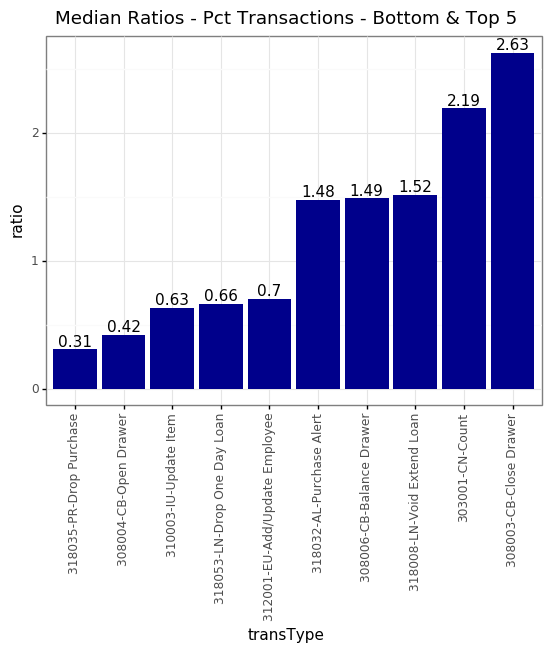

<ggplot: (-9223372029268794487)>

In [18]:
(
top_tail_ratio_pct >>
    ggplot() +
    geom_col(aes(x = 'transType', y = 'ratio'), fill = 'darkblue') +
    theme_bw() +
    ggtitle('Median Ratios - Pct Transactions - Bottom & Top 5') +
    #scale_x_discrete(limits = list(top_tail_ratio_pct.transType.values)) +
    theme(axis_text_x = element_text(angle = 90)) +
    geom_text(aes(x = 'transType', y = 'ratio', label = 'ratio.round(2)'),
              va = 'bottom')
)

## Total Trans - Means ratios - System error vs no error

To compare the differences between the number of transactions for each transactions type, the average of this number will be calculated for those minutes when a system error ocurred and 60 minutes before the error ocurred.

With these averages a ratio will be calculated to obtain which transactions types had more differences when a sysem error happened.

$$Ratio_{TransType} = \frac{NumberTrans^{[0.5]-SystemError}_{TransType}}{\overline{NumberTrans^{[0.5]-NoSystemError}_{TransType}}}$$

In [19]:
ratio_num=(
df_relevant >>
    group_by(X.transType, X.ind_sys_error) >>
    summarise(avg = X.num_transactions.median()) >>
    ungroup() >>
    group_by(X.transType) >>
    mutate(avg_0 = X.avg.shift(1))  >>
    ungroup() >>
    mutate(ratio = X.avg/X.avg_0)
).dropna().sort_values(['ratio'])

In [20]:
top_tail_ratio_num = ratio_num.head(5).append(ratio_num.tail(5))
top_tail_ratio_num['transType'] = pd.Categorical(top_tail_ratio_num['transType'],categories=top_tail_ratio_num['transType'].values)

In [21]:
(
top_tail_ratio_num >>
    ggplot() +
    geom_col(aes(x = 'transType', y = 'ratio'), fill = 'darkblue') +
    theme_bw() +
    ggtitle('Median Ratios - Number of Transactions - Bottom & Top 5') +
    #scale_x_discrete(limits = list(top_tail_ratio_pct.transType.values)) +
    theme(axis_text_x = element_text(angle = 90)) +
    geom_text(aes(x = 'transType', y = 'ratio', label = 'ratio.round(2)'),
              va = 'bottom')
)

<ggplot: (-9223372029238973580)>

## % Box Plot - Transaction with highest ratio

/anaconda3/lib/python3.7/site-packages/plotnine/layer.py:360: UserWarning: stat_boxplot : Removed 211 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)


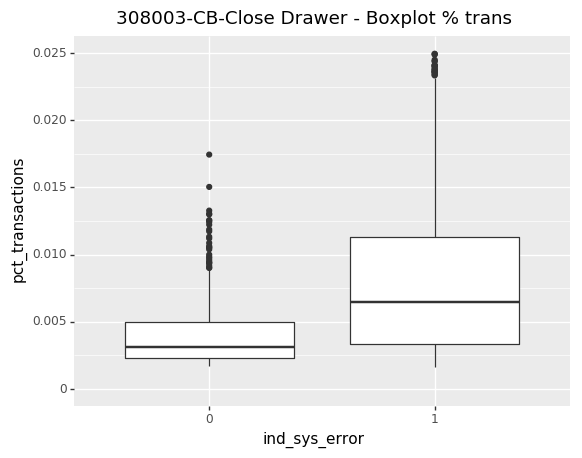

<ggplot: (-9223372029296267092)>

In [22]:
(
df_relevant >>
    mutate(ind_sys_error = X.ind_sys_error.astype('str')) >>
    mask(X.transType == '308003-CB-Close Drawer') >>
    ggplot() +
    geom_boxplot(aes(x = 'ind_sys_error', y = 'pct_transactions')) +
    ggtitle('308003-CB-Close Drawer - Boxplot % trans') +
    scale_y_continuous(limits = [0,0.025])
)

## Number Box Plot - Transaction with highest ratio

/anaconda3/lib/python3.7/site-packages/plotnine/layer.py:360: UserWarning: stat_boxplot : Removed 356 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)


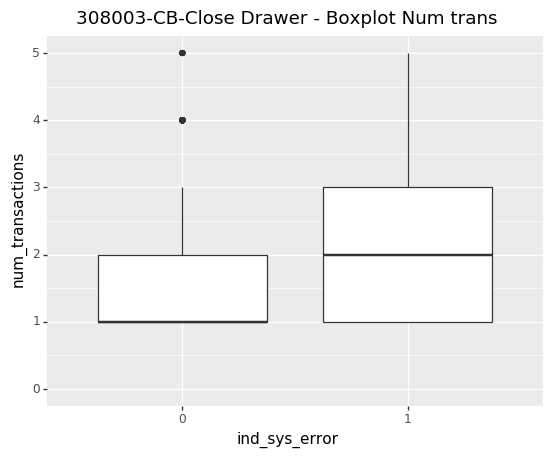

<ggplot: (7557792681)>

In [23]:
(
df_relevant >>
    mutate(ind_sys_error = X.ind_sys_error.astype('str')) >>
    mask(X.transType == '308003-CB-Close Drawer') >>
    ggplot() +
    geom_boxplot(aes(x = 'ind_sys_error', y = 'num_transactions')) +
    ggtitle('308003-CB-Close Drawer - Boxplot Num trans') +
    scale_y_continuous(limits = [0,5])
)

# GBM Model

A GBM will be fitted to obtain the most important features, and also to try to find some insights that predicts a possible new system error.

## Initiate H2O

Inititate H2O, indicating the memory to use

In [19]:
h2o.init(max_mem_size = "13G", nthreads=-1)

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.2" 2019-01-15; OpenJDK Runtime Environment 18.9 (build 11.0.2+9); OpenJDK 64-Bit Server VM 18.9 (build 11.0.2+9, mixed mode)
  Starting server from /anaconda3/lib/python3.7/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/dz/y365nyjn6kqgc1k6dc68xkg00000gp/T/tmpf0w9sja1
  JVM stdout: /var/folders/dz/y365nyjn6kqgc1k6dc68xkg00000gp/T/tmpf0w9sja1/h2o_darias_started_from_python.out
  JVM stderr: /var/folders/dz/y365nyjn6kqgc1k6dc68xkg00000gp/T/tmpf0w9sja1/h2o_darias_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


--------------------------  ---------------------------------------------------
H2O cluster uptime:         02 secs
H2O cluster timezone:       America/Mexico_City
H2O data parsing timezone:  UTC
H2O cluster version:        3.26.0.1
H2O cluster version age:    6 days
H2O cluster name:           H2O_from_python_darias_yl8rq7
H2O cluster total nodes:    1
H2O cluster free memory:    13 Gb
H2O cluster total cores:    12
H2O cluster allowed cores:  12
H2O cluster status:         accepting new members, healthy
H2O connection url:         http://127.0.0.1:54321
H2O connection proxy:
H2O internal security:      False
H2O API Extensions:         Amazon S3, XGBoost, Algos, AutoML, Core V3, Core V4
Python version:             3.7.1 final
--------------------------  ---------------------------------------------------

## Create H2O Data

Create a H2O Data Frame

In [20]:
df_h2o=h2o.H2OFrame(df_relevant)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [21]:
df_h2o['ind_sys_error']=df_h2o['ind_sys_error'].asfactor()

In [22]:
df_h2o['transType']=df_h2o['transType'].asfactor()

## Split Data

Split in _train & test_

In [23]:
train, test = df_h2o.split_frame(ratios=[0.8], seed=1234)

## X & Y

Lists with X & y

In [24]:
x=['transType', 'num_transactions', 'pct_transactions']
y='ind_sys_error'

## Grid

Finding the best metaparameter

In [25]:
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.grid.grid_search import H2OGridSearch

In [26]:
hyper_parameters = {'learn_rate': [0.001, 0.01, 0.1, 0.5],
                    'max_depth': [3,4,5],
                    'ntrees': [10,50,100]}

search_criteria = { 'strategy': "RandomDiscrete",
                    'seed': 42,
                    'stopping_metric': "AUC", 
                    'stopping_tolerance': 0.001,
                    'stopping_rounds': 5 }

In [27]:
grid_gbm=H2OGridSearch(H2OGradientBoostingEstimator(),
                       hyper_parameters,
                       grid_id="random_plus_manual",
                       search_criteria=search_criteria)

In [28]:
grid_gbm.train(x=x,
               y=y,
               training_frame=train,
               #ntrees=200,
               seed=1,
               nfolds=2,
               balance_classes=True)

gbm Grid Build progress: |████████████████████████████████████████████████| 100%


In [29]:
grid_gbm_list=grid_gbm.get_grid(sort_by='auc', decreasing=True)
grid_gbm_list

     learn_rate max_depth ntrees                    model_ids  \
0           0.1         5    100  random_plus_manual_model_21   
1           0.5         4     50  random_plus_manual_model_36   
2           0.5         4    100  random_plus_manual_model_27   
3           0.1         4    100  random_plus_manual_model_13   
4           0.5         3    100  random_plus_manual_model_24   
5           0.5         5    100   random_plus_manual_model_6   
6           0.5         5     50  random_plus_manual_model_22   
7           0.1         5     50  random_plus_manual_model_19   
8           0.5         3     50  random_plus_manual_model_26   
9           0.5         5     10  random_plus_manual_model_33   
10          0.1         3    100  random_plus_manual_model_10   
11          0.1         4     50  random_plus_manual_model_35   
12          0.5         4     10   random_plus_manual_model_9   
13          0.1         3     50   random_plus_manual_model_8   
14          0.5         3

## Best Model

Best model of all created in the grid

In [30]:
best_gbm = grid_gbm_list.models[0]

Save the model

In [43]:
h2o.save_model(model=best_gbm,
               path='/Users/darias/Documents/POS_Anomaly_detection/H2O_models',
               force=True)

'/Users/darias/Documents/POS_Anomaly_detection/H2O_models/random_plus_manual_model_21'

Load model if neccesary

In [39]:
#best_gbm = h2o.load_model('/Users/darias/Documents/POS_Anomaly_detection/H2O_models/random_plus_manual_model_21')

## Variable Importance

In [31]:
imp=best_gbm.varimp()
imp=pd.DataFrame(imp)

In [32]:
imp=(
 imp >>
    rename(variable            = 0,
           relative_importance = 1,
           scaled_importance   = 2,
           percentage          = 3)
)

In [33]:
(
 imp.head(5) >>
    mutate(scaled_importance = X.scaled_importance*100) >>
    mutate(scaled_importance = X.scaled_importance.round(1)) >>
    ggplot() +
    geom_bar(aes(x='variable', y='scaled_importance'), stat='identity', fill='darkblue') +
    ggtitle('Variable Importance - Top 5') +
    scale_x_discrete(limits = imp.head(5) >> arrange(X.relative_importance) >> select(X.variable) >> pull) +
    theme(axis_text_x=element_text(angle=90, face='bold', size=10),
          axis_text_y=element_text(face='bold', size=10)) +
    theme_bw() +
    coord_flip() +
    geom_text(aes(x='variable',y='scaled_importance',label='scaled_importance'), ha='left', format_string='{}%', size = 10)
)

<ggplot: (-9223372029293306757)>

## Marginal Effects

Marginal Effects for the Top 3 variable Importance

PartialDependencePlot progress: |█████████████████████████████████████████| 100%


/anaconda3/lib/python3.7/site-packages/plotnine/layer.py:517: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  return not cbook.iterable(value) and (cbook.is_numlike(value) or


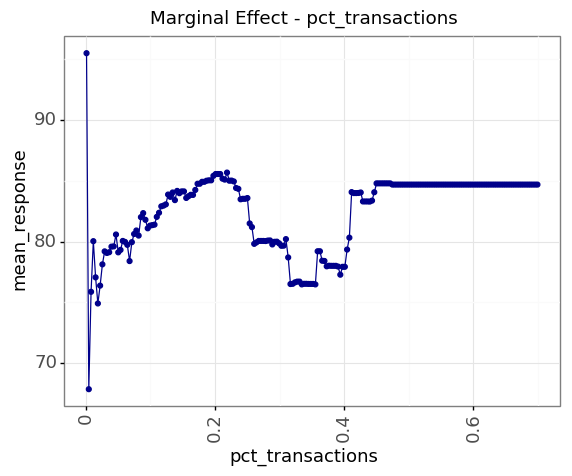

<ggplot: (7561528191)>

In [34]:
df_pp_1=best_gbm.partial_plot(cols=[imp.variable.values[0]],data=test, plot=False, nbins=200)
df_pp_1=df_pp_1[0].as_data_frame()

df_pp_1=df_pp_1.sort_values(['pct_transactions'])

(
 df_pp_1 >>
    mutate(mean_response=(X.mean_response*100).round(2)) >>
    ggplot() +
    geom_point(aes(x = 'pct_transactions', y = 'mean_response'), colour = 'darkblue') +
    geom_line(aes(x = 'pct_transactions', y = 'mean_response', group = 1), colour = 'darkblue') +
    theme_bw() +
    ggtitle('Marginal Effect - ' + imp.variable.values[0]) +
    theme(axis_text_x=element_text(angle=90,size=13),
          axis_text_y=element_text(size=13),
          axis_title_x=element_text(size=13),
          axis_title_y=element_text(size=13))
)

In [35]:
df_pp_1.head()

pct_transactions  mean_response  stddev_response  std_error_mean_response
0          0.000943       0.955148         0.040754                 0.000318
1          0.004452       0.678422         0.203346                 0.001587
2          0.007961       0.758595         0.173703                 0.001356
3          0.011470       0.800264         0.162118                 0.001265
4          0.014979       0.770482         0.192397                 0.001502

PartialDependencePlot progress: |█████████████████████████████████████████| 100%


/anaconda3/lib/python3.7/site-packages/plotnine/layer.py:517: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  return not cbook.iterable(value) and (cbook.is_numlike(value) or


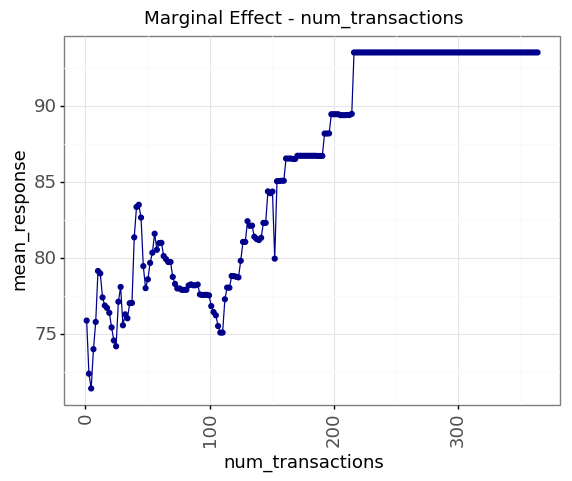

<ggplot: (7561510043)>

In [36]:
df_pp_2=best_gbm.partial_plot(cols=[imp.variable.values[1]],data=test, plot=False, nbins=200)
df_pp_2=df_pp_2[0].as_data_frame()

df_pp_2=df_pp_2.sort_values(['num_transactions'])

(
 df_pp_2 >>
    mutate(mean_response=(X.mean_response*100).round(2)) >>
    ggplot() +
    geom_point(aes(x = 'num_transactions', y = 'mean_response'), colour = 'darkblue') +
    geom_line(aes(x = 'num_transactions', y = 'mean_response', group = 1), colour = 'darkblue') +
    theme_bw() +
    ggtitle('Marginal Effect - ' + imp.variable.values[1]) +
    theme(axis_text_x=element_text(angle=90,size=13),
          axis_text_y=element_text(size=13),
          axis_title_x=element_text(size=13),
          axis_title_y=element_text(size=13))
)

In [37]:
df_pp_2.head()

num_transactions  mean_response  stddev_response  std_error_mean_response
0          1.000000       0.758837         0.263541                 0.002057
1          2.824121       0.723920         0.226609                 0.001769
2          4.648241       0.714193         0.204460                 0.001596
3          6.472362       0.740022         0.185505                 0.001448
4          8.296482       0.757858         0.185844                 0.001450

PartialDependencePlot progress: |█████████████████████████████████████████| 100%


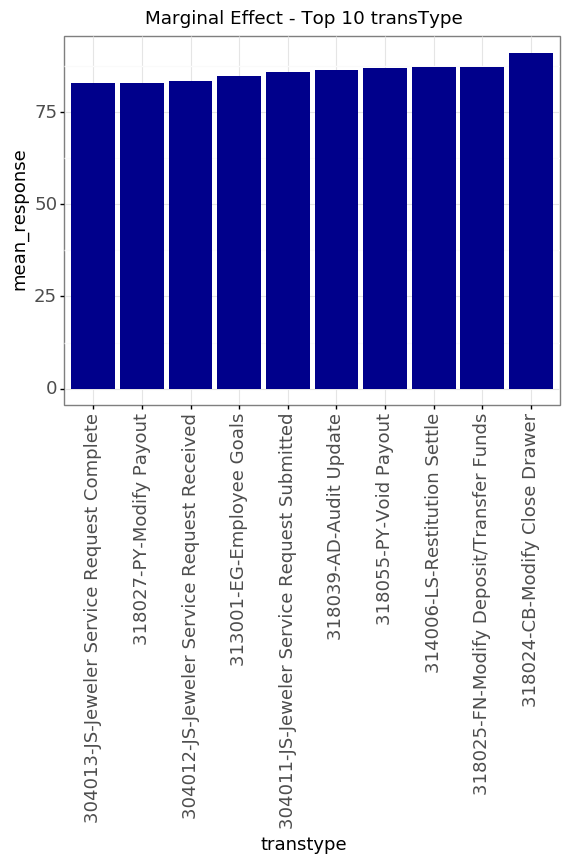

<ggplot: (7561707328)>

In [38]:
df_pp_3=best_gbm.partial_plot(cols=[imp.variable.values[2]],data=test, nbins = 90, plot=False)
df_pp_3=df_pp_3[0].as_data_frame()

df_pp_3=df_pp_3.sort_values(['mean_response'], ascending = False).head(10)

df_pp_3=df_pp_3.sort_values(['mean_response'], ascending = True)

df_pp_3['transtype'] = pd.Categorical(df_pp_3['transtype'],categories=df_pp_3['transtype'].values)

(
 df_pp_3 >>
    mutate(mean_response=(X.mean_response*100).round(2)) >>
    ggplot() +
    geom_col(aes(x = 'transtype', y = 'mean_response'), fill = 'darkblue') +
    theme_bw() +
    ggtitle('Marginal Effect - Top 10 ' + imp.variable.values[2]) +
    theme(axis_text_x=element_text(angle=90,size=13),
          axis_text_y=element_text(size=13),
          axis_title_x=element_text(size=13),
          axis_title_y=element_text(size=13))
)

### Feature Distribution

Distribution of the most important feature

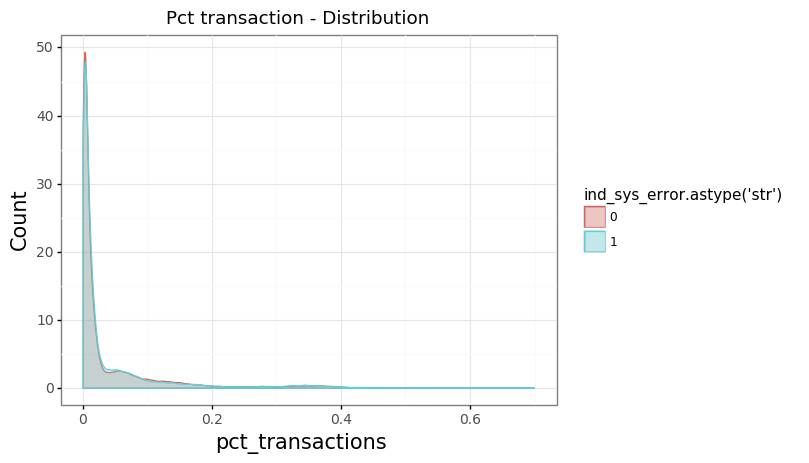

<ggplot: (7555843739)>

In [46]:
(
 df_relevant >>
    ggplot() +
    geom_density(aes(x = 'pct_transactions',
                     group = "ind_sys_error.astype('str')",
                     colour = "ind_sys_error.astype('str')",
                     fill = "ind_sys_error.astype('str')"), alpha = 0.3) +
    theme_bw() +
    ggtitle('Pct transaction - Distribution ') +
    ylab('Count') +
    theme(axis_title_y=element_text(size=15),
          axis_title_x=element_text(size=15),
          axis_text_y=element_text(size=10),
          axis_text_x=element_text(size=10))
)

## AUC

In [47]:
perf_train=best_gbm.model_performance(train)
perf_test=best_gbm.model_performance(test)

In [48]:
ll={'desc':['Train', 'test'],'Coeficiente':[perf_train.auc(),
                                                     perf_test.auc()]}
ll=pd.DataFrame(ll)

orden_ll=(
 ll >>
    select('desc') >>
    pull
)

(
 ll >>
    mutate(Coeficiente = X.Coeficiente.round(2)) >>
    ggplot() +
    geom_bar(aes(x='desc',y='Coeficiente'),stat='identity',fill='darkblue') +
    scale_x_discrete(limits = orden_ll) +
    geom_text(aes(x='desc', y='Coeficiente', label='Coeficiente'), va='bottom') +
    theme_bw() +
    ggtitle('AUC')
)

<ggplot: (-9223372029306068725)>

## Confussion Matrix

In [89]:
best_gbm.model_performance(test).confusion_matrix()

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.34939959581842966: 


0     1      Error    Rate
-----  ----  -----  -------  ----------------
0      2779  5372   0.6591   (5372.0/8151.0)
1      1147  7119   0.1388   (1147.0/8266.0)
Total  3926  12491  0.3971   (6519.0/16417.0)

## Performance

In [90]:
best_gbm.model_performance(test)


ModelMetricsBinomial: gbm
** Reported on test data. **

MSE: 0.20587493243346988
RMSE: 0.45373442941159964
LogLoss: 0.5971152924629509
Mean Per-Class Error: 0.31599626045803797
AUC: 0.7325859562860849
pr_auc: 0.7568831987589487
Gini: 0.46517191257216983
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.34939959581842966: 


0     1      Error    Rate
-----  ----  -----  -------  ----------------
0      2779  5372   0.6591   (5372.0/8151.0)
1      1147  7119   0.1388   (1147.0/8266.0)
Total  3926  12491  0.3971   (6519.0/16417.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.3494       0.685937  308
max f2                       0.182715     0.835829  382
max f0point5                 0.571985     0.703077  177
max accuracy                 0.52015      0.683072  202
max precision                0.986919     1         0
max recall                   0.125627     1         388
max specificity              0.986919     1         0
max absolute_mcc             0.571985     0.384359  177
max min_per_class_accuracy   0.433371     0.671909  249
max mean_per_class_accuracy  0.52015      0.684004  202

Gains/Lift Table: Avg response rate: 50.35 %, avg score: 50.19 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101724                   0.939303           1.9623    1.9623             0.988024         0.959427  0.988024                    0.959427            0.0199613       0.0199613                  96.2302   96.2302
    2        0.0200402                   0.911885           1.92479   1.94383            0.969136         0.923867  0.978723                    0.941917            0.0189935       0.0389548                  92.4789   94.383
    3        0.0300298                   0.884301           1.85287   1.91357            0.932927         0.897811  0.963489                    0.927245            0.0185096       0.0574643                  85.2874   91.3573
    4        0.0400195                   0.860789           1.7681    1.87726            0.890244         0.873054  0.945205                    0.913718            0.0176627       0.075127                   76.8102   87.7261
    5        0.05007                     0.850542           1.84164   1.87011            0.927273         0.854868  0.941606                    0.901905            0.0185096       0.0936366                  84.1645   87.0112
    6        0.100018                    0.807948           1.6906    1.78046            0.85122          0.830562  0.896468                    0.866277            0.0844423       0.178079                   69.0597   78.0463
    7        0.150088                    0.75718            1.63333   1.73138            0.822384         0.780919  0.871753                    0.837801            0.0817808       0.25986                    63.3328   73.1378
    8        0.200037                    0.705512           1.56465   1.68975            0.787805         0.733061  0.850792                    0.811648            0.0781515       0.338011                   56.4649   68.9747
    9        0.299994                    0.594742           1.34826   1.57597            0.678854         0.648989  0.793503                    0.75745             0.134769        0.47278                    34.8264   57.5966
    10       0.400012                    0.491831           1.08497   1.4532             0.546285         0.540466  0.731689                    0.703196            0.108517        0.581297                   8.49699   45.3198
    11       0.50003                     0.431923           0.907165  1.34398            0.45676          0.458191  0.676696                    0.654189            0.0907331       0.67203                    -9.28345  34.3978
    12       0.600597                    0.394734           0.748241  1.24423            0.376741         0.412555  0.626471                    0.613729            0.075248        0.747278                   -25.1759  24.4225
    13       0.70025                     0.364293           0.710184  1.16823            0.357579         0.379788  0.588205                    0.580437            0.0707718       0.81805                    -28.9816  16.8226
    14       0.800146                    0.340352           0.679387  1.1072             0.342073         0.352025  0.557476                    0.55192             0.0678684       0.885918                   -32.0613  10.7195
    15       0.900164                    0.31289            0.615663  1.05258            0.309988         0.327914  0.529977                    0.52703             0.0615775       0.947496                   -38.4337  5.25807
    16       1                           0.0232683          0.525907  1                  0.264796         0.275108  0.503502                    0.50188           

## Efectiveness

Test prediction

In [49]:
est_valid=best_gbm.predict(test)
est_valid=est_valid.as_data_frame()
est_valid=est_valid['p1']

gbm prediction progress: |████████████████████████████████████████████████| 100%


Test observed data

In [50]:
obs_valid=test['ind_sys_error']
obs_valid=obs_valid.as_data_frame()

Predicted vs Observed

In [51]:
obs_est=(
 obs_valid >>
    mutate(est = est_valid) >>
    rename(obs='y')
)

Create percentiles

In [52]:
obs_est['per']=pd.qcut(obs_est.est, q=[0.01,0.1,0.2,0.3,0.4,0.5,
                                       0.6,0.7,0.8,0.9,1.0], 
                                   labels=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0])

Efectiveness per quantiles

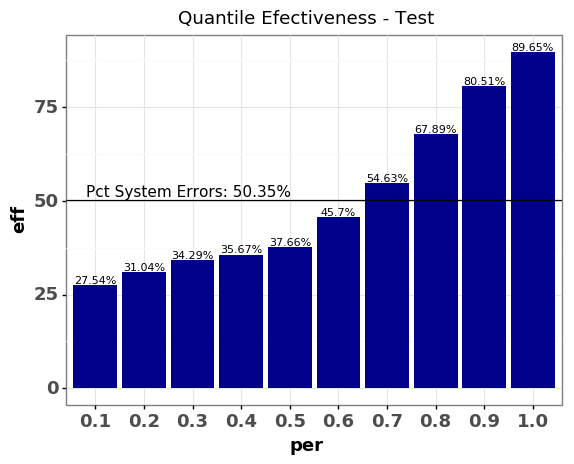

<ggplot: (-9223372029296400731)>

In [53]:
pct_1=(
 obs_est >>
    mutate(obs = X.ind_sys_error.astype('int')) >>
    summarize(pct = X.obs.sum()/len(obs_est)) >>
    pull
)

(
 obs_est >>
    mutate(obs = X.ind_sys_error.astype('int')) >>
    group_by(X.per) >>
    summarize(n = n(X.ind_sys_error),
              vp = X.ind_sys_error.sum()) >>
    mutate(eff = X.vp/X.n*100) >>
    mutate(eff = X.eff.round(2)) >>
    ggplot() +
    geom_bar(aes(x = 'per', y = 'eff'), stat = 'identity', fill = 'darkblue') +
    theme_bw() +
    ggtitle('Quantile Efectiveness - Test') +
    theme(axis_text_x  = element_text(size = 13, face = 'bold'),
          axis_text_y  = element_text(size = 13, face = 'bold'),
          axis_title_x = element_text(size = 13, face = 'bold'),
          axis_title_y = element_text(size = 13, face = 'bold')) +
    geom_text(aes(x='per',y='eff',label='eff'),va='bottom',size=8,format_string='{}%') +
    geom_hline(yintercept=pct_1*100) +
    annotate(geom  = 'text',
             x     = 0.8,
             y     = pct_1*100,
             label = 'Pct System Errors: '+(100*pct_1).round(2).astype('str')+'%',
             ha    = 'left',
             va    = 'bottom')
)

In [54]:
df_relevant.to_csv('/Users/darias/Documents/POS_Anomaly_detection/transType_historic_60min_before.csv')